In [238]:
import src.backtest_utils as sbtu
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import src.utils.regime as sur
import src.utils.pd_accessors as pda
import numpy as np
import src.scanner as scanner

In [239]:
_data_loader = sbtu.DataLoader.init_from_paths('other.json', 'base.json')
_strategy_path = _data_loader.file_path('strategy_lookup.pkl')
with open(_strategy_path, 'rb') as f:
    _strategy_lookup = pickle.load(f)

_entry_path = _data_loader.file_path('entry_table_15m.pkl')
with open(_entry_path, 'rb') as f:
    _entry_table = pickle.load(f)

_peak_path = _data_loader.file_path('peak_table_15m.pkl')
with open(_peak_path, 'rb') as f:
    _peak_table = pickle.load(f)

_bench_str = 'SPY'
_interval = '15m'
_price_data = pd.read_csv(_data_loader.history_path(_bench_str, _interval), index_col=0, header=[0,1]).astype('float64')
_bench = pd.read_csv(_data_loader.bench_path(_bench_str, _interval), index_col=0).astype('float64')
_relative_rebased = sbtu.PriceGlob(_price_data).relative_rebased(_bench.close)
_strategy_overview = pd.read_csv(_data_loader.file_path('stat_overview_15m.csv'))

_price_data_by_symbol = sbtu.PriceGlob(_price_data).swap_level()

<AxesSubplot:>

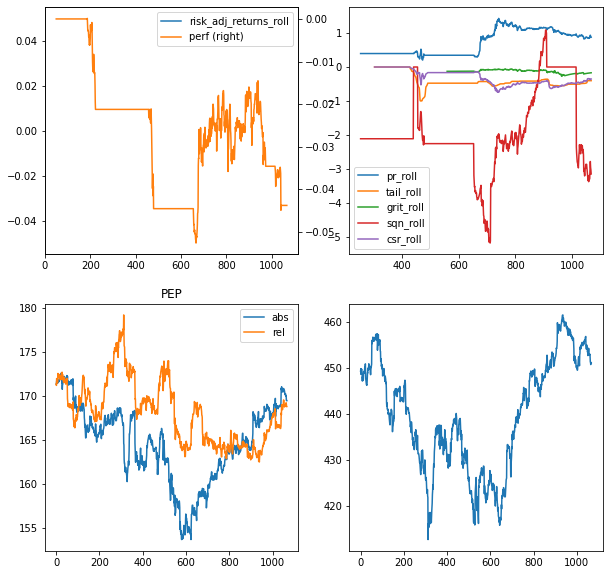

In [248]:
symbol = 'PEP'
_strat_data = _strategy_lookup[symbol]
_stats = _strategy_lookup[symbol].stat_historical
fig, axs = plt.subplots(2, 2)
_stats[['risk_adj_returns_roll', 'perf']].plot(secondary_y=['perf'], ax=axs[0, 0], figsize=[10,10])
plot_copy = _stats[['pr_roll', 'tail_roll', 'grit_roll', 'sqn_roll', 'csr_roll']]
plot_copy.plot(ax=axs[0, 1])

def get_abs_rel(_s):
    sd = _price_data_by_symbol.data[_s]
    rel = sur.simple_relative(sd, _bench.close).close
    return pd.DataFrame(
        data={
            'abs': sd.close,
            'rel': rel
        }
    )

_symbol_data = _price_data_by_symbol.data[symbol]
get_abs_rel(symbol).plot(title=symbol, ax=axs[1, 0])
_bench.close.plot(ax=axs[1, 1])

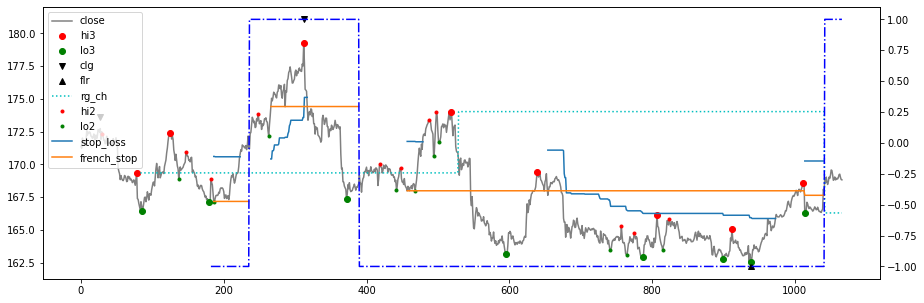

In [249]:


epd = _strategy_lookup[symbol].enhanced_price_data.copy()
epd['french_stop'] = _strategy_lookup[symbol].french_stop.stop_price
_sl = _strategy_lookup[symbol].stop_loss_series
_sl = _sl.loc[~_sl.index.duplicated(keep='first')]
epd['stop_loss'] = _sl
# epd['base_close'] = _symbol_data.close
scanner.enhanced_price_data_plot(epd)

In [250]:

_pt = _strategy_lookup[symbol].peak_table.copy()
# _pt = pda.PeakTable(_pt)
# _pt = _pt.unpivot(_symbol_data.index)
# _pt = _pt.loc[~_pt.index.duplicated(keep='first')]
def filter_duplicates(sw):
    return sw.loc[~sw.index.duplicated(keep='first')]

_shi_px = _pt.loc[(_pt.type == -1)].set_index('end')
_shi_1 = _shi_px.loc[(_shi_px.lvl == 1)]
_shi_1 = filter_duplicates(_shi_1)
_shi_2 = _shi_px.loc[(_shi_px.lvl == 2)]
_shi_2 = filter_duplicates(_shi_2)
_shi_3 = _shi_px.loc[(_shi_px.lvl == 3)]
_shi_3 = filter_duplicates(_shi_3)

_slo_px = _pt.loc[(_pt.type == 1)].set_index('end')
_slo_1 = _slo_px.loc[(_slo_px.lvl == 1)]
_slo_1 = filter_duplicates(_slo_1)
_slo_2 = _slo_px.loc[(_slo_px.lvl == 2)]
_slo_2 = filter_duplicates(_slo_2)
_slo_3 = _slo_px.loc[(_slo_px.lvl == 3)]
_slo_3 = filter_duplicates(_slo_3)

epd['hi1_lag'] = _shi_1.en_px
epd['hi2_lag'] = _shi_2.en_px
epd['hi3_lag'] = _shi_3.en_px
epd['lo1_lag'] = _slo_1.en_px
epd['lo2_lag'] = _slo_2.en_px
epd['lo3_lag'] = _slo_3.en_px

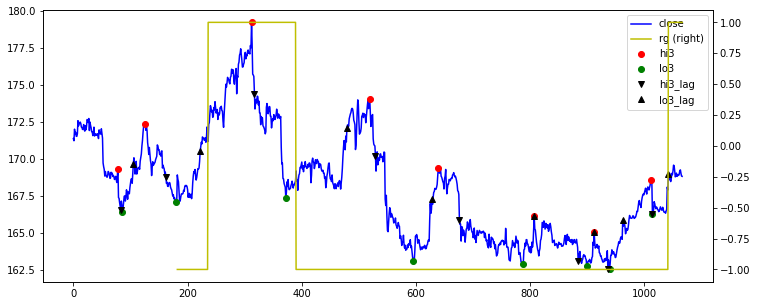

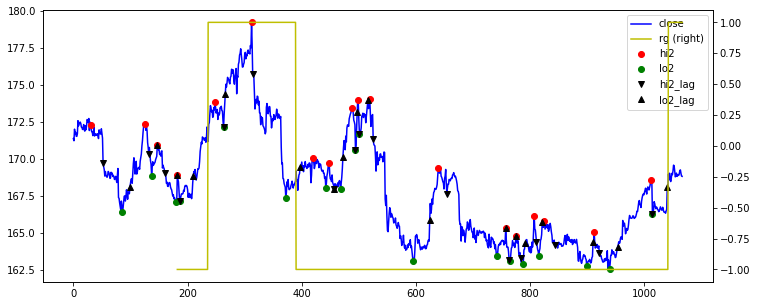

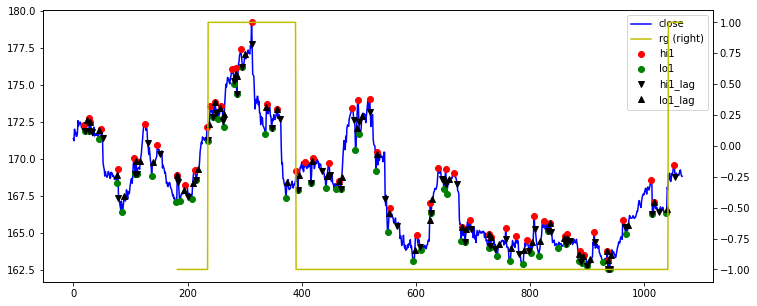

In [251]:
import src.utils.regime as regime
import matplotlib.pyplot as plt

_epd_plt = epd[['close', 'hi2', 'lo2', 'hi3', 'lo3', 'rg']]

def plot(lvl):
    epd[[
        'close', 'rg',
        f'hi{lvl}', f'lo{lvl}',
        f'hi{lvl}_lag', f'lo{lvl}_lag',
    ]].plot(style=['b', 'y', 'ro', 'go', 'kv', 'k^'], figsize=[12, 5], secondary_y='rg')

plot(3)
plot(2)
plot(1)

<AxesSubplot:title={'center':'lvl3 lag'}, ylabel='Frequency'>

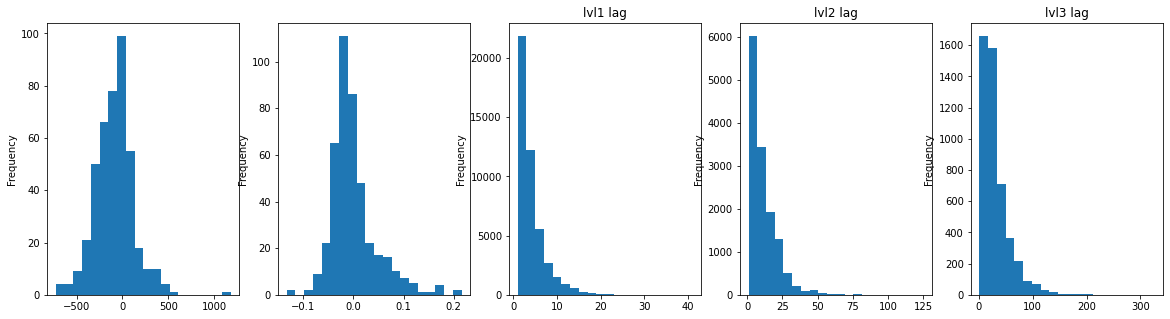

In [252]:
fig, axs = plt.subplots(1, 5)
_strategy_overview.weight_total.plot.hist(bins=20, ax=axs[0], figsize=(20, 5))
_strategy_overview.perf.plot.hist(bins=20, ax=axs[1])

_peak_table['peak_lag'] = _peak_table.end - _peak_table.start
partial_exit_lag = _entry_table.partial_exit_date - _entry_table.entry
_peak_table.loc[_peak_table.lvl == 1, 'peak_lag'].plot.hist(bins=20, ax=axs[2], title='lvl1 lag')
_peak_table.loc[_peak_table.lvl == 2, 'peak_lag'].plot.hist(bins=20, ax=axs[3], title='lvl2 lag')
_peak_table.loc[_peak_table.lvl == 3, 'peak_lag'].plot.hist(bins=20, ax=axs[4], title='lvl3 lag')

In [253]:
_entry_table['r'] = (_entry_table.fixed_stop_price - _entry_table.en_px) / _entry_table.en_px
_prev_exits = _entry_table.loc[
    (_entry_table.exit_signal_date != _symbol_data.index[-1])
].copy()
_prev_exits['sig_len'] = (_prev_exits.exit_signal_date - _prev_exits.entry)
_prev_exits['partial_sig_len'] = (_prev_exits.partial_exit_date - _prev_exits.entry)

In [254]:
sw = _peak_table.loc[(_peak_table.lvl == 3)].copy()
sw['sw_px_gap'] = (sw.en_px.shift(1) - sw.en_px) * sw.type
sw.loc[sw.symbol != sw.symbol.shift(1), 'sw_px_gap'] = np.nan
c = sw.sw_px_gap.loc[sw.sw_px_gap < 0].count()
win_rate = c / len(sw.loc[sw.sw_px_gap.notna()])
avg_win = sw.sw_px_gap.loc[sw.sw_px_gap < 0].sum() / len(sw.loc[sw.sw_px_gap.notna()]) * -1
avg_loss = sw.sw_px_gap.loc[sw.sw_px_gap > 0].sum() / len(sw.loc[sw.sw_px_gap.notna()])
win_rate * avg_win - (1-win_rate) * avg_loss

# lim = 2.5
# sw.sw_px_gap.loc[(sw.sw_px_gap < lim) & (sw.sw_px_gap > -lim)].plot.hist(bins=20)

0.9562128750681891

,start,end,type,lvl,st_px,en_px,symbol,peak_lag,sw_diff
10,97,122,1,3,159.287910,162.338277,MMM,25,NaN
13,125,130,-1,3,163.114391,160.282930,MMM,5,28.0
40,337,348,1,3,150.751880,154.748595,MMM,11,212.0
42,356,392,-1,3,155.756498,151.664947,MMM,36,19.0
49,416,520,1,3,150.518617,155.017114,MMM,104,60.0
...,...,...,...,...,...,...,...,...,...
121,936,962,1,3,185.671342,189.467844,ZTS,26,24.0
130,964,986,-1,3,190.889533,187.263829,ZTS,22,28.0
132,988,1005,1,3,186.544767,190.189794,ZTS,17,24.0
136,1010,1018,-1,3,190.380475,186.483107,ZTS,8,22.0


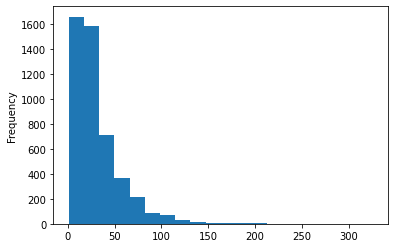

In [255]:
lvl1 = _peak_table.loc[_peak_table.lvl == 3].copy()
lvl1['sw_diff'] = (lvl1.start - lvl1.start.shift(1))
lvl1.loc[lvl1.symbol != lvl1.symbol.shift(1), 'sw_diff'] = np.nan
lvl1.peak_lag.plot.hist(bins=20)
lvl1